In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Part 1: Build a GAN from scratch on 2D Sine Wave and Spiral

Training on Sine Wave Dataset
[0] D Loss: 1.5632, G Loss: 0.8335
[1000] D Loss: 1.3393, G Loss: 0.7370
[2000] D Loss: 1.3683, G Loss: 0.7423
[3000] D Loss: 1.3224, G Loss: 0.7049
[4000] D Loss: 1.3649, G Loss: 0.7063
[0] D Loss: 1.3846, G Loss: 0.6816
[1000] D Loss: 1.1571, G Loss: 1.1269
[2000] D Loss: 1.4276, G Loss: 0.7289
[3000] D Loss: 1.3709, G Loss: 0.7393
[4000] D Loss: 1.3689, G Loss: 0.7485


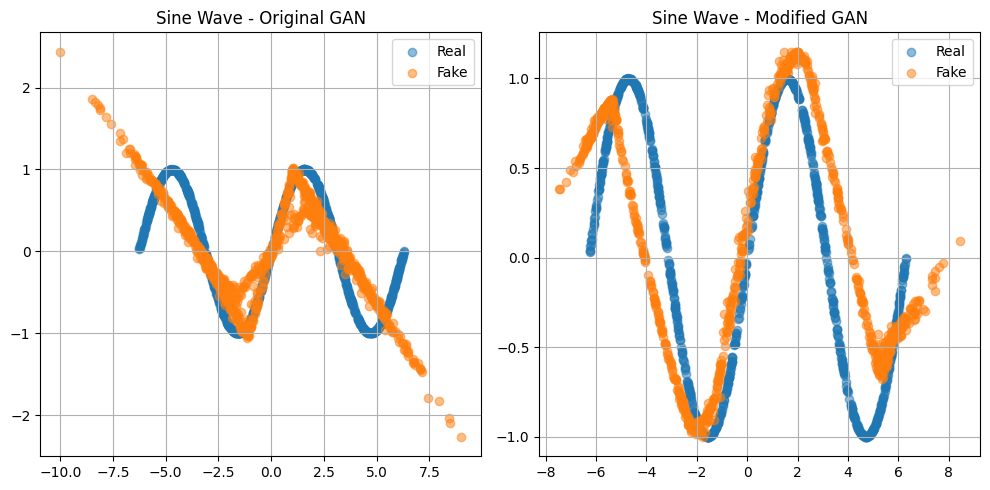


Training on Spiral Dataset
[0] D Loss: 2.0450, G Loss: 0.7094
[1000] D Loss: 0.9937, G Loss: 1.3112
[2000] D Loss: 1.5225, G Loss: 0.6756
[3000] D Loss: 1.3483, G Loss: 0.7241
[4000] D Loss: 1.2995, G Loss: 0.7591
[0] D Loss: 1.4330, G Loss: 0.6905
[1000] D Loss: 1.1752, G Loss: 0.8683
[2000] D Loss: 1.3064, G Loss: 0.7999
[3000] D Loss: 1.3689, G Loss: 0.6760
[4000] D Loss: 1.3381, G Loss: 0.7688


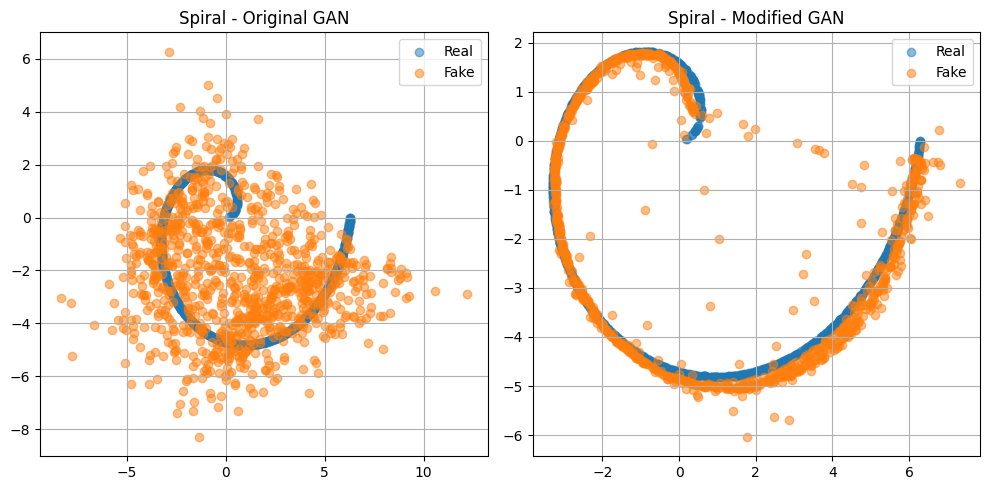

In [9]:
#Step1: Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Step2: Data Generation Functions
def generate_sine_wave(n=1000):
    x = np.random.uniform(-2 * np.pi, 2 * np.pi, n)
    y = np.sin(x)
    data = np.stack([x, y], axis=1)
    return torch.tensor(data, dtype=torch.float32)

def generate_spiral(n=1000):
    theta = np.sqrt(np.random.rand(n)) * 2 * np.pi
    r = theta
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    data = np.stack([x, y], axis=1)
    return torch.tensor(data, dtype=torch.float32)

# Step3: GAN Architectures
# Original Generator
class GeneratorOriginal(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=16, output_dim=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.model(x)

# Original Discriminator
class DiscriminatorOriginal(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=16):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# Modified Generator (Deeper + LeakyReLU + optional Tanh)
class GeneratorModified(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.model(x)

# Modified Discriminator (Deeper + LeakyReLU)
class DiscriminatorModified(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# Step4: GAN Training Function
def train_gan(G, D, real_data_func, noise_dim=2, epochs=5000):
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(G.parameters(), lr=0.001)
    optimizer_D = optim.Adam(D.parameters(), lr=0.001)

    for epoch in range(epochs):
        real_data = real_data_func(128)
        noise = torch.randn(128, noise_dim)
        fake_data = G(noise)

        real_labels = torch.ones(128, 1)
        fake_labels = torch.zeros(128, 1)

        # Discriminator step
        d_loss = criterion(D(real_data), real_labels) + criterion(D(fake_data.detach()), fake_labels)
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Generator step
        g_loss = criterion(D(fake_data), real_labels)
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        if epoch % 1000 == 0:
            print(f"[{epoch}] D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    return G

# Step5: Plotting Function
def plot_comparison(G_orig, G_mod, real_data_func, title1, title2):
    noise = torch.randn(1000, 2)
    fake1 = G_orig(noise).detach().numpy()
    fake2 = G_mod(noise).detach().numpy()
    real = real_data_func(1000).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].scatter(real[:, 0], real[:, 1], alpha=0.5, label='Real')
    axes[0].scatter(fake1[:, 0], fake1[:, 1], alpha=0.5, label='Fake')
    axes[0].set_title(title1)
    axes[0].legend()
    axes[0].grid(True)

    axes[1].scatter(real[:, 0], real[:, 1], alpha=0.5, label='Real')
    axes[1].scatter(fake2[:, 0], fake2[:, 1], alpha=0.5, label='Fake')
    axes[1].set_title(title2)
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Step6: Train and Compare on Sine Wave
print("Training on Sine Wave Dataset")
G_sine_orig = train_gan(GeneratorOriginal(), DiscriminatorOriginal(), generate_sine_wave)
G_sine_mod  = train_gan(GeneratorModified(), DiscriminatorModified(), generate_sine_wave)
plot_comparison(G_sine_orig, G_sine_mod, generate_sine_wave,
                title1="Sine Wave - Original GAN", title2="Sine Wave - Modified GAN")

# Step7: Train and Compare on Spiral
print("\nTraining on Spiral Dataset")
G_spiral_orig = train_gan(GeneratorOriginal(), DiscriminatorOriginal(), generate_spiral)
G_spiral_mod  = train_gan(GeneratorModified(), DiscriminatorModified(), generate_spiral, epochs=5000) #Spiral usually needs more training
plot_comparison(G_spiral_orig, G_spiral_mod, generate_spiral,
                title1="Spiral - Original GAN", title2="Spiral - Modified GAN")


#Part 2: Real-World GAN on PathMNIST

In [1]:
# Install MedMNIST
!pip install medmnist


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha2

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from medmnist import INFO, PathMNIST
from medmnist.dataset import PathMNIST
from torchvision import transforms
from torch.utils.data import DataLoader


100%|██████████| 206M/206M [00:08<00:00, 23.8MB/s]


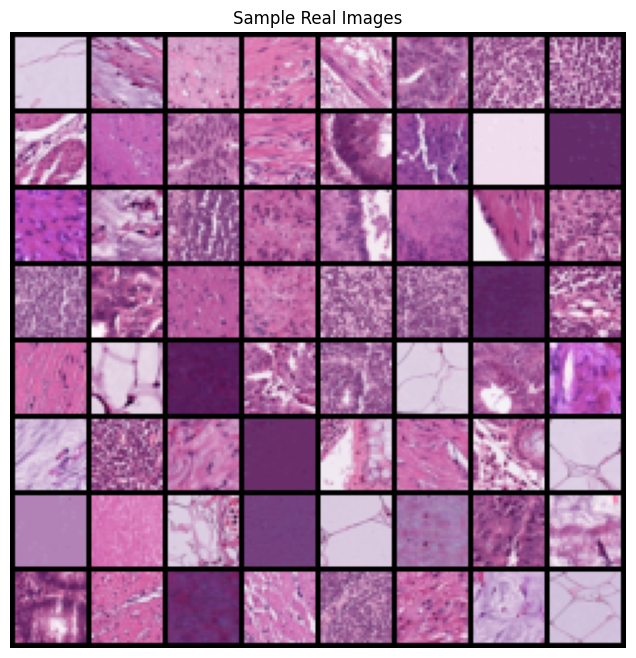

In [3]:
#Step1: Dataset configuration
data_flag = 'pathmnist'
download = True
info = INFO[data_flag]
n_classes = len(info['label'])  # Used for cGAN extension

## Convert image to tensor and normalize RGB channels to [-1, 1] for GAN training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # For 3 channels
])

# Loading dataset (ONLY 28x28 version)
train_dataset = PathMNIST(split='train', transform=transform, download=download)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

# Optional: visualize samples
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_samples(dataset):
    imgs = torch.stack([dataset[i][0] for i in range(64)])
    grid = make_grid(imgs, nrow=8, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title("Sample Real Images")
    plt.show()

show_samples(train_dataset)

In [4]:
#Step 2: Define DCGAN Models
import torch.nn as nn

LATENT_DIM = 100

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(100, 256, 7, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),  # OUTPUT: 3 channels
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # INPUT: 3 channels
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

[1/30] Loss D: 1.1165, Loss G: 1.6331
[2/30] Loss D: 0.4856, Loss G: 2.1461
[3/30] Loss D: 0.2212, Loss G: 2.7611
[4/30] Loss D: 0.0407, Loss G: 5.0620
[5/30] Loss D: 0.1131, Loss G: 5.4838
[6/30] Loss D: 0.1435, Loss G: 3.5231
[7/30] Loss D: 0.4875, Loss G: 5.9326
[8/30] Loss D: 0.0391, Loss G: 5.7048
[9/30] Loss D: 0.8680, Loss G: 3.9408
[10/30] Loss D: 0.0585, Loss G: 4.0219


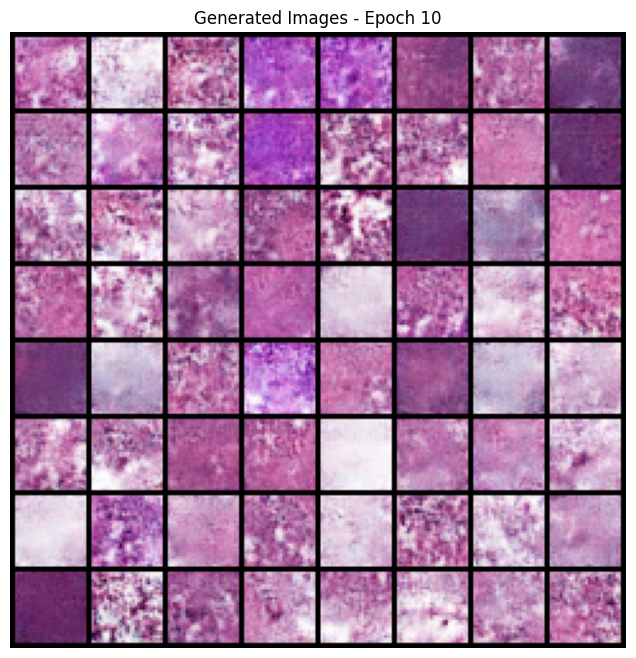

[11/30] Loss D: 0.2667, Loss G: 3.0659
[12/30] Loss D: 0.0432, Loss G: 4.9874
[13/30] Loss D: 0.1310, Loss G: 2.5730
[14/30] Loss D: 0.1906, Loss G: 6.8108
[15/30] Loss D: 0.4168, Loss G: 2.5770
[16/30] Loss D: 0.7736, Loss G: 7.2319
[17/30] Loss D: 0.4029, Loss G: 4.0865
[18/30] Loss D: 0.1917, Loss G: 3.7259
[19/30] Loss D: 0.3740, Loss G: 7.7517
[20/30] Loss D: 1.0606, Loss G: 1.3693


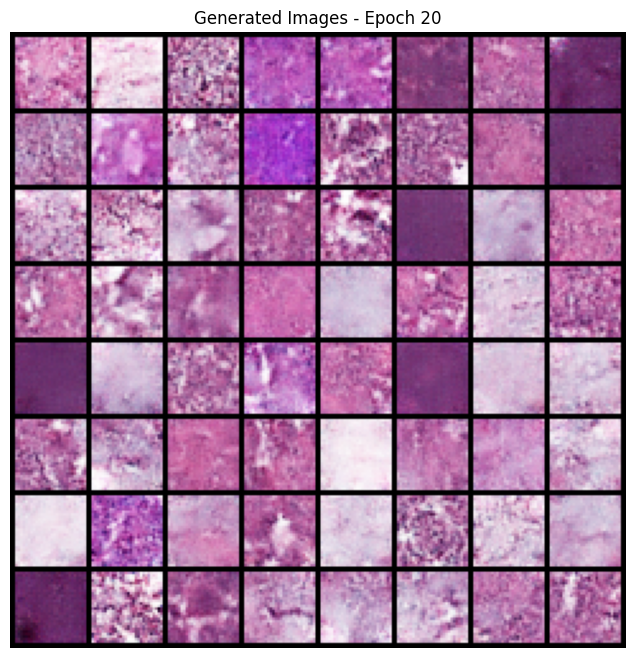

[21/30] Loss D: 0.0529, Loss G: 5.7270
[22/30] Loss D: 1.1156, Loss G: 3.6827
[23/30] Loss D: 0.1038, Loss G: 4.2942
[24/30] Loss D: 0.0775, Loss G: 4.5807
[25/30] Loss D: 0.0053, Loss G: 10.5482
[26/30] Loss D: 0.0268, Loss G: 7.2004
[27/30] Loss D: 0.2218, Loss G: 6.7599
[28/30] Loss D: 0.3443, Loss G: 2.9985
[29/30] Loss D: 1.0624, Loss G: 2.0124
[30/30] Loss D: 0.3464, Loss G: 4.9774


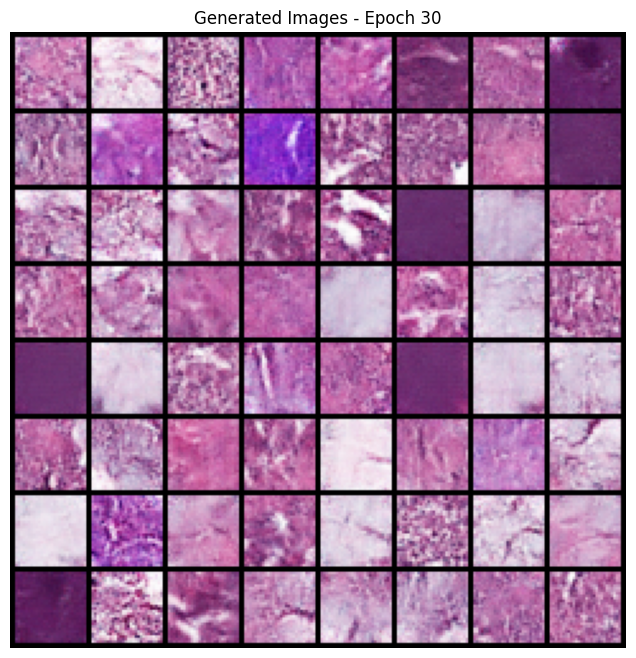

In [5]:
#Step 3: Train DCGAN
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 30
fixed_noise = torch.randn(64, LATENT_DIM, 1, 1, device=device)

losses_G = []
losses_D = []

for epoch in range(num_epochs):
    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Generate fake images
        noise = torch.randn(batch_size, LATENT_DIM, 1, 1, device=device)
        fake_imgs = G(noise)

        # Train Discriminator
        D_real = D(real_imgs)
        D_fake = D(fake_imgs.detach())
        loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        D_fake = D(fake_imgs)
        loss_G = criterion(D_fake, real_labels)
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    losses_D.append(loss_D.item())
    losses_G.append(loss_G.item())

    print(f"[{epoch+1}/{num_epochs}] Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

    # Show generated images every few epochs
    if (epoch+1) % 10 == 0:
        G.eval()
        with torch.no_grad():
            gen_imgs = G(fixed_noise).cpu()
        grid = make_grid(gen_imgs, nrow=8, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0))
        plt.title(f"Generated Images - Epoch {epoch+1}")
        plt.axis("off")
        plt.show()
        G.train()



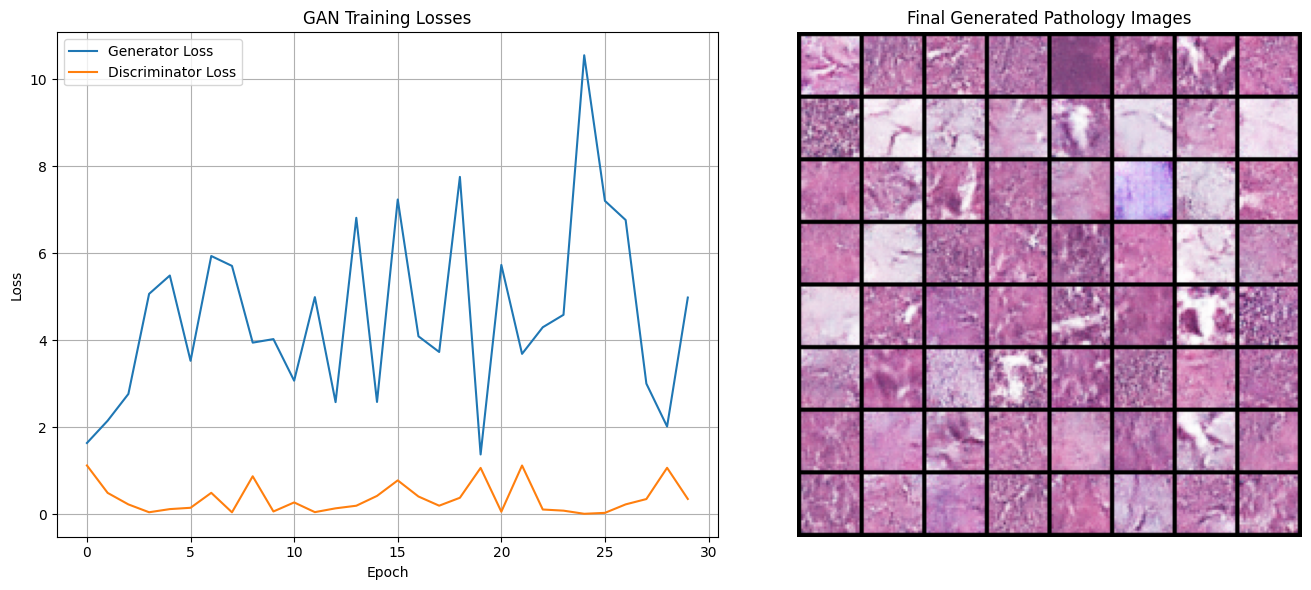

In [6]:
#step 4: Visualize Losses and Compare Real vs Fake
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Create a side-by-side plot
def plot_losses_and_generated_images(generator, losses_G, losses_D):
    # Set up subplots: 1 row, 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # --- Plot 1: Loss curves ---
    axs[0].plot(losses_G, label="Generator Loss")
    axs[0].plot(losses_D, label="Discriminator Loss")
    axs[0].set_title("GAN Training Losses")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    # --- Plot 2: Generated images ---
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(64, LATENT_DIM, 1, 1).to(device)
        fake_imgs = generator(noise).detach().cpu()
        fake_imgs = (fake_imgs + 1) / 2  # Undo normalization from [-1,1] to [0,1]
    grid = make_grid(fake_imgs, nrow=8)

    axs[1].imshow(grid.permute(1, 2, 0))
    axs[1].axis("off")
    axs[1].set_title("Final Generated Pathology Images")

    plt.tight_layout()
    plt.show()

# Call the function
plot_losses_and_generated_images(G, losses_G, losses_D)


#Extension: Implementing a conditional GAN (cGAN)

Epoch 1/30 | Loss D: 1.6921 | Loss G: 0.6284
Epoch 2/30 | Loss D: 1.4929 | Loss G: 0.7279
Epoch 3/30 | Loss D: 1.3241 | Loss G: 0.7085
Epoch 4/30 | Loss D: 1.5389 | Loss G: 0.9071
Epoch 5/30 | Loss D: 1.3222 | Loss G: 0.7236
Epoch 6/30 | Loss D: 1.4576 | Loss G: 0.6300
Epoch 7/30 | Loss D: 1.0123 | Loss G: 1.4279
Epoch 8/30 | Loss D: 1.4668 | Loss G: 0.9329
Epoch 9/30 | Loss D: 1.3762 | Loss G: 0.5984
Epoch 10/30 | Loss D: 1.5449 | Loss G: 0.6654


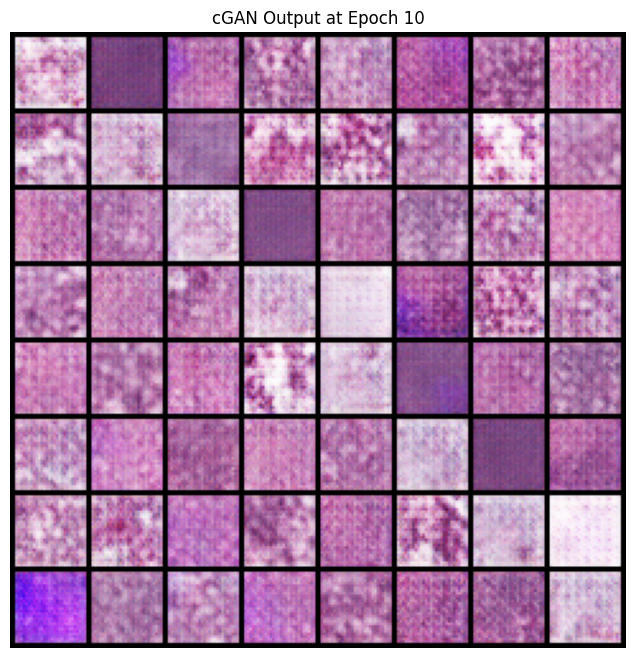

Epoch 11/30 | Loss D: 1.4728 | Loss G: 0.2492
Epoch 12/30 | Loss D: 1.4551 | Loss G: 2.4506
Epoch 13/30 | Loss D: 1.6079 | Loss G: 0.2771
Epoch 14/30 | Loss D: 1.4580 | Loss G: 0.6496
Epoch 15/30 | Loss D: 1.8243 | Loss G: 0.4670
Epoch 16/30 | Loss D: 1.2992 | Loss G: 1.0405
Epoch 17/30 | Loss D: 1.4032 | Loss G: 0.3094
Epoch 18/30 | Loss D: 1.4463 | Loss G: 2.8417
Epoch 19/30 | Loss D: 1.2810 | Loss G: 2.2581
Epoch 20/30 | Loss D: 0.7546 | Loss G: 3.5016


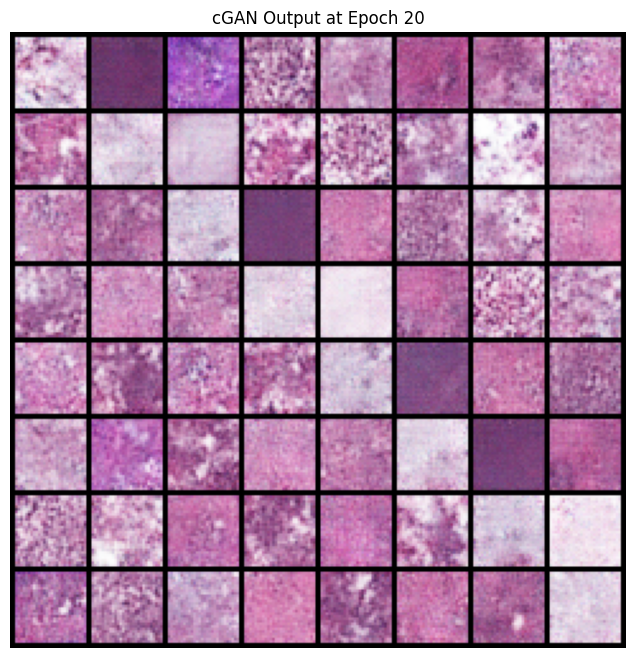

Epoch 21/30 | Loss D: 1.4600 | Loss G: 2.1826
Epoch 22/30 | Loss D: 0.5712 | Loss G: 1.2473
Epoch 23/30 | Loss D: 0.6538 | Loss G: 1.3522
Epoch 24/30 | Loss D: 1.1631 | Loss G: 0.8140
Epoch 25/30 | Loss D: 1.2292 | Loss G: 2.1794
Epoch 26/30 | Loss D: 0.1273 | Loss G: 3.8683
Epoch 27/30 | Loss D: 1.0494 | Loss G: 1.4956
Epoch 28/30 | Loss D: 1.1506 | Loss G: 2.1823
Epoch 29/30 | Loss D: 0.3272 | Loss G: 2.4224
Epoch 30/30 | Loss D: 0.8703 | Loss G: 1.4347


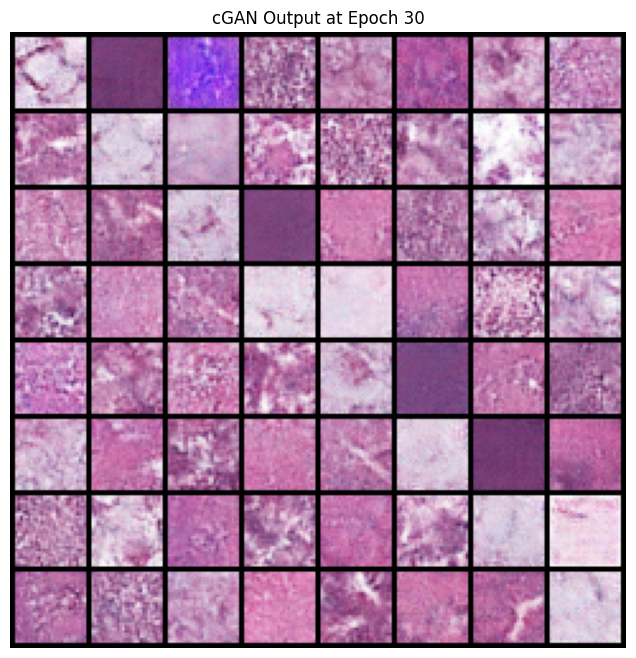

In [7]:
#importing the same libraries again just for clarification
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from medmnist import INFO, PathMNIST
import matplotlib.pyplot as plt

# Dataset setup
data_flag = 'pathmnist'
info = INFO[data_flag]
n_classes = len(info['label'])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = PathMNIST(split='train', transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
LATENT_DIM = 100

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, n_classes):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + n_classes, 256, 7, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),  # RGB
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([noise, label_embedding], dim=1)
        x = x.view(x.size(0), -1, 1, 1)
        return self.gen(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.disc = nn.Sequential(
            nn.Conv2d(3 + n_classes, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embedding = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        label_embedding = label_embedding.expand(labels.size(0), n_classes, img.size(2), img.size(3))
        x = torch.cat([img, label_embedding], dim=1)
        return self.disc(x)

# Initialize models
G = Generator(LATENT_DIM, n_classes).to(device)
D = Discriminator(n_classes).to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Fixed labels for visual testing
fixed_noise = torch.randn(64, LATENT_DIM, device=device)
fixed_labels = torch.tensor([i % n_classes for i in range(64)], device=device)

# Training loop
epochs = 30
losses_G, losses_D = [], []

for epoch in range(epochs):
    for real_imgs, labels in train_loader:
        real_imgs, labels = real_imgs.to(device), labels.squeeze().to(device)
        b_size = real_imgs.size(0)
        real_targets = torch.ones(b_size, 1, device=device)
        fake_targets = torch.zeros(b_size, 1, device=device)

        # Train Discriminator
        noise = torch.randn(b_size, LATENT_DIM, device=device)
        fake_imgs = G(noise, labels)
        D_real = D(real_imgs, labels)
        D_fake = D(fake_imgs.detach(), labels)
        loss_D = criterion(D_real, real_targets) + criterion(D_fake, fake_targets)
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        output = D(fake_imgs, labels)
        loss_G = criterion(output, real_targets)
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    losses_G.append(loss_G.item())
    losses_D.append(loss_D.item())
    print(f"Epoch {epoch+1}/{epochs} | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            fake_imgs = G(fixed_noise, fixed_labels).detach().cpu()
            fake_imgs = (fake_imgs + 1) / 2
            grid = make_grid(fake_imgs, nrow=8)
            plt.figure(figsize=(8, 8))
            plt.imshow(grid.permute(1, 2, 0))
            plt.title(f"cGAN Output at Epoch {epoch+1}")
            plt.axis("off")
            plt.show()


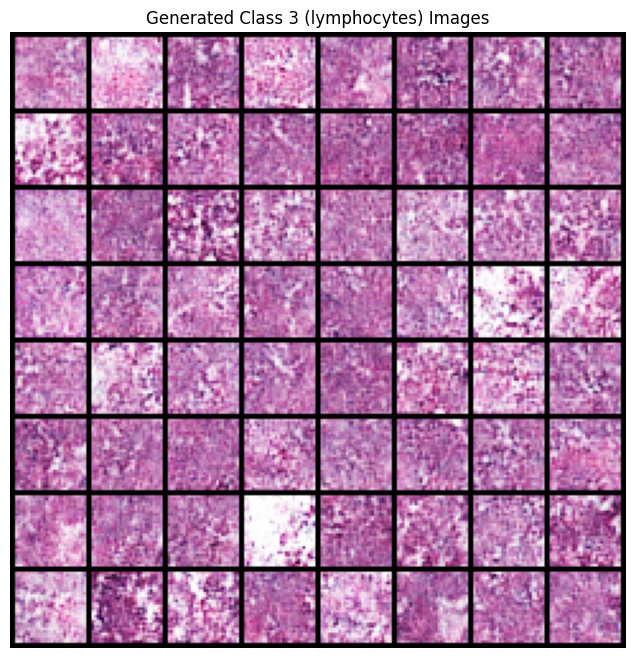

In [8]:
# Generate fake "class 3" images (lymphocytes, for example)
label = torch.tensor([3] * 64).to(device)
noise = torch.randn(64, LATENT_DIM).to(device)
with torch.no_grad():
    imgs = G(noise, label).detach().cpu()
    imgs = (imgs + 1) / 2
    grid = make_grid(imgs, nrow=8)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title("Generated Class 3 (lymphocytes) Images")
    plt.axis("off")
    plt.show()